In [1]:
import MDAnalysis
from clustercode import ClusterEnsemble
import matplotlib 
import matplotlib.pyplot as plt

In [2]:
'''
This is a small atomistic trajectory including a single large micelle of aggregation number 100.
The Micelle is composed of SDS which has a HSO4 headgroup and carbon tail groups 
'''
xtc = "files/traj_small.xtc"
tpr = "files/topol_small.tpr"

# First we are going to look at the trajectory with some basic MDAnalysis commands
universe = MDAnalysis.Universe(tpr, xtc)

atom_names = set(universe.atoms.names)
residue_names = set(universe.residues.resnames)
atom_number = universe.atoms.n_atoms
residue_number = universe.residues.n_residues
print('Residue names: {:s}'.format(', '.join(residue_names)))
print('Number of residiue: {:d}'.format(residue_number))
print('Atom names: {:s}'.format(', '.join(atom_names)))
print('Number of atoms: {:d}'.format(atom_number))
print('Length of trajectory: {:d}'.format(universe.trajectory.n_frames))

Residue names: Cl, Na, SOL, SDS
Number of residiue: 6130
Atom names: OS2, S, C11, C4, C7, C12, C5, C8, OS3, Na, C1, C2, OW, C10, C3, Cl, C9, OS4, HW2, HW1, C6, OS1
Number of atoms: 19174
Length of trajectory: 71


In [3]:
'''
We want two molecules to be considered in a cluster when their carbon tails are close enough together. 
Therefore the 'cluster_objects' will be C1 - C12
We initialise the ClusterEnsemble object as follows:
'''
cluster_objects = ['C{:d}'.format(i) for i in range(1,13)]

ClstrEns = ClusterEnsemble(tpr, xtc, cluster_objects)

In [4]:
'''
Run the analysis for each frame within the specified times. cut-off is in Angstroem and describes how close two
objects need to be to considered in the same cluster. This still depends on the measure parameter which is either
centre of geometry (COG), centre of mass (COM) or bead to bead (b2b). 
'''
ClstrEns.cluster_analysis(cut_off=7.5, times=(60e3, 70e3), measure="COM", algorithm="dynamic", work_in="Residue", style="atom")

In [5]:
# This trajectory is larger and describes the inital phase of micellisations
xtc = "files/traj_large.xtc"
tpr = "files/topol_large.tpr"
ClstrEns = ClusterEnsemble(tpr, xtc, cluster_objects)

In [6]:
ClstrEns.cluster_analysis(cut_off=3.5, times=(0, 10000), measure="COM", algorithm="dynamic", work_in="Residue", style="atom")

In [7]:
"""
These function will be added to the object soond as of now they are 
here to use.
"""
def get_cluster_size(cluster_list, frame):
    '''
    This function calculates the size of cluster in a single frame
    '''
    return [len(cluster) for cluster in cluster_list[frame]]

def get_cluster_sizes(cluster_list, first=None, last=None, stride=1):
    '''
    This function calculates the sizes of clusters in multiple frames.
    start and stop are measured in frames.
    '''
    if first is None: first = 0
    if last is None: last = len(cluster_list)
    cluster_sizes = []
    frames = (first, last, stride)
    for frame in range(first, last, stride):
        cluster_sizes.append(get_cluster_size(cluster_list, frame))
    return cluster_sizes

In [8]:
cluster_list = ClstrEns.cluster_list
# Get the size distribution of clusters in the first frame:
frame_0_clusters = ClstrEns.cluster_sizes[50]
def print_clusters(frames, i):
    print('Cluter sizes in {:d}. frame: {:s}'.format(i, ', '.join([str(item) for item in frames])))
print_clusters(frame_0_clusters, 0)

# Get the size distribution of several frames (from 50 to 54 here). 
# The return value of _get_cluster_size and _get_cluster_sizes is actually 
# a list and list of list respectively
frames_clusters = ClstrEns.cluster_sizes[50:55]
for frame, i in zip(frames_clusters, range(50, 55)):
    print_clusters(frame, i)

Cluter sizes in 0. frame: 28, 112, 47, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 50. frame: 28, 112, 47, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 51. frame: 28, 112, 47, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 52. frame: 28, 78, 47, 34, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 53. frame: 28, 11, 67, 47, 34, 27, 41, 83, 4, 21, 29, 7, 1
Cluter sizes in 54. frame: 28, 119, 47, 34, 27, 83, 4, 21, 29, 7, 1


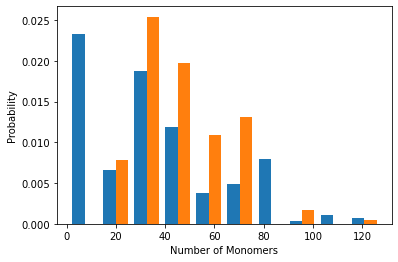

In [9]:
fig, ax = plt.subplots()
ClstrEns.plot_histogram(ax, frames=[(50, 70, 1), (180, 200, 1)], density=True, maxbins=False)

In [19]:
'''
In the cluster_list we have all a list of molecules in each cluter.
We can therefore calculate all kinds of things with it.
'''
ClstrEns.universe.trajectory.rewind()
n_frame = 50
n_cluster = 1
for i, this_cluster in enumerate(ClstrEns.cluster_list):
    print(i)
    if i == n_frame:
        special_cluster = this_cluster[n_cluster]
        break


# A cluster is a Residuegroup, we can use all the methods defined for
# Residuegroups
print('Type of special_cluster: {:s}'.format(type(special_cluster).__name__))

COM = special_cluster.center_of_mass()
print('Centre of mass: {:.2f}, {:.2f}, {:.2f}'.format(*COM))
print('Centre of geomety: {:.2f}, {:.2f}, {:.2f}'.format(*special_cluster.center_of_geometry()))
print('Radius of gyration: {:.3f}'.format(special_cluster.radius_of_gyration()))
print('Ids of residues(molecules) in this cluster: ')
print(special_cluster.resids)
print('Type of residues(molecules) in this cluster: ')
print(special_cluster.resnames)


Type of special_cluster: ResidueGroup
Centre of mass: 54.12, 31.19, 38.87
Centre of geomety: 54.14, 31.20, 38.82
Radius of gyration: 32.367
Ids of residues(molecules) in this cluster: 
[  1  10  25  26  27  43  45  49  54  63  64  68  71  78  99 101 109 111
 116 124 126 127 128 131 132 139 153 154 166 175 179 184 194 198 202 219
 224 229 246 248 262 267 269 273 275 276 290 295 299 300 305 314 325 333
 342 346 355 356 368 373 374 379 380 381 384 390 397]
Type of residues(molecules) in this cluster: 
['SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS']


In [18]:
'''
In the cluster_list we have all a list of molecules in each cluter.
We can therefore calculate all kinds of things with it.
'''

ClstrEns.universe.trajectory.rewind()
n_frame = 50
n_cluster = 1
for i, this_cluster in enumerate(ClstrEns.cluster_list):
    print(i)
    if i == n_frame:
        special_cluster = this_cluster[n_cluster]
        print(special_cluster)
        ClstrEns.unwrap_cluster(special_cluster, verbosity=1)

        break

# A cluster is a Residuegroup, we can use all the methods defined for
# Residuegroups
print('Type of special_cluster: {:s}'.format(type(special_cluster).__name__))

COM = special_cluster.center_of_mass()
print('Centre of mass: {:.2f}, {:.2f}, {:.2f}'.format(*COM))
print('Centre of geomety: {:.2f}, {:.2f}, {:.2f}'.format(*special_cluster.center_of_geometry()))
print('Radius of gyration: {:.3f}'.format(special_cluster.radius_of_gyration()))
print('Ids of residues(molecules) in this cluster: ')
print(special_cluster.resids)
print('Type of residues(molecules) in this cluster: ')
print(special_cluster.resnames)

Type of special_cluster: ResidueGroup
Centre of mass: 54.12, 31.19, 38.87
Centre of geomety: 54.14, 31.20, 38.82
Radius of gyration: 32.367
Ids of residues(molecules) in this cluster: 
[  1  10  25  26  27  43  45  49  54  63  64  68  71  78  99 101 109 111
 116 124 126 127 128 131 132 139 153 154 166 175 179 184 194 198 202 219
 224 229 246 248 262 267 269 273 275 276 290 295 299 300 305 314 325 333
 342 346 355 356 368 373 374 379 380 381 384 390 397]
Type of residues(molecules) in this cluster: 
['SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS'
 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS' 'SDS']
